# FIT5202 2025 S2 Assignment 1 : Analysing Australian Property Market Data

## Table of Contents
* [Part 1 : Working with RDD](#part-1)  
    - [1.1 Data Preparation and Loading](#1.1)  
    - [1.2 Data Partitioning in RDD](#1.2)  
    - [1.3 Query/Analysis](#1.3)  
* [Part 2 : Working with DataFrames](#2-dataframes)  
    - [2.1 Data Preparation and Loading](#2-dataframes)  
    - [2.2 Query/Analysis](#2.2)  
* [Part 3 :  RDDs vs DataFrame vs Spark SQL](#part-3)  

Note: Feel free to add Code/Markdown cells as you need.

# Part 1 : Working with RDDs (30%) <a class="anchor" name="part-1"></a>
## 1.1 Working with RDD
In this section, you will need to create RDDs from the given datasets, perform partitioning in these RDDs and use various RDD operations to answer the queries. 

1.1.1 Data Preparation and Loading <a class="anchor" name="1.1"></a>
1.	Write the code to create a SparkContext object using SparkSession. To create a SparkSession, you first need to build a SparkConf object that contains information about your application. Use Melbourne time as the session timezone. Give your application an appropriate name and run Spark locally with 4 cores on your machine.

In [1]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[4]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Assignment1"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Method 1: Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).config("spark.sql.session.timeZone", "GMT+10").getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

1.1.2 Load the CSV and JSON files into multiple RDDs. 

In [2]:
import os
files = ["data/council.json", "data/nsw_property_price.csv", "data/property_purpose.json", "data/zoning.json"]
rdds = []  
headers = {}
for file in files:
    # get file extension
    ext = os.path.splitext(file)[1].lower()  
    # filter out whitespace
    rdd = (
        sc.textFile(file)
          .map(lambda x: x.strip().rstrip(",").replace("{", "").replace("}", ""))
          .filter(lambda x: x != "")
    )

    if ext == ".json":
        rdds.append((rdd, "json", file))
    elif ext == ".csv":
        rdds.append((rdd, "csv", file))

1.1.3 For each RDD, remove the header rows and display the total count and the first 8 records.


In [3]:
import csv
from io import StringIO

def safe_dict(it):
    """Safely turn iterable of kv pairs into dict, skipping malformed entries."""
    d = {}
    for kv in it:
        if isinstance(kv, tuple) and len(kv) == 2:
            k, v = kv
            d[k] = v
    return d

def parse_csv_line(line: str):
    """Safely parse a CSV line, handling commas inside quoted fields."""
    reader = csv.reader(StringIO(line), quotechar='"', delimiter=',')
    return next(reader)

def process_rdd(rdd, ext, filename):
    # remove header
    header = rdd.first()
    clean_header = header.split("\\n", 1)[0]
    if clean_header.startswith('"') and not clean_header.endswith('"'):
        clean_header += '"'  # restore the closing quote
    headers[filename] = clean_header
    lines = rdd.filter(lambda s: s != header)

    
    if ext == "json":        
        # robust key:value parsing (handles both "key : value" and "key": "value")
        kv = (
            lines
            .map(lambda s: s.strip())
            .filter(lambda s: ":" in s)              # accept any colon, with or without spaces
            .map(lambda s: s.split(":", 1))          # split once, keep right side intact
            .filter(lambda kv: len(kv) == 2)         # keep only well-formed pairs
            .map(lambda kv: (kv[0].strip(' "\',{}'), kv[1].strip(' "\',{}')))
        )

        # group into records (assumes each record spans 2 lines)
        grouped = (
            kv.zipWithIndex()
              .map(lambda x: (x[1] // 2, x[0]))
              .groupByKey()
              .mapValues(safe_dict)
              .values()
        )

        print(f"{filename}: Total count={grouped.count()}, first 8 rows:\n{grouped.take(8)}\n")
        return grouped
    
    if ext == "csv":
        # use robust CSV parsing instead of naive split
        fieldnames = parse_csv_line(headers[filename])
        lines = (
            lines.map(lambda row: dict(zip(fieldnames, parse_csv_line(row))))
        )
        
        print(f"{filename}: Total count={lines.count()}, first 8 rows:\n{lines.take(8)}\n")
        return lines

# Replace items in rdds
rdds = [
    (process_rdd(rdd, ext, filename), ext, filename)
    for (rdd, ext, filename) in rdds
]


data/council.json: Total count=220, first 8 rows:
[{'council_id': '1', 'council_name': '003'}, {'council_id': '3', 'council_name': '013'}, {'council_id': '5', 'council_name': '020'}, {'council_id': '7', 'council_name': '022'}, {'council_id': '9', 'council_name': '026'}, {'council_id': '11', 'council_name': '029'}, {'council_id': '13', 'council_name': '034'}, {'council_id': '15', 'council_name': '037'}]

data/nsw_property_price.csv: Total count=4854814, first 8 rows:
[{'property_id': '4270509', 'purchase_price': '1400000.00', 'address': '8 C NYARI RD, KENTHURST', 'post_code': '2156', 'property_type': 'house', 'strata_lot_number': '', 'property_name': '', 'area': '2.044', 'area_type': 'H', 'iso_contract_date': '2023-12-14', 'iso_settlement_date': '2024-02-14', 'nature_of_property': 'V', 'legal_description': '2/1229857', 'id': '142', 'council_id': '200', 'purpose_id': '9922', 'zone_id': '53'}, {'property_id': '4329326', 'purchase_price': '1105000.00', 'address': '82 CAMARERO ST, BOX HILL'

1.1.4 Drop records with invalid information: purpose_id or council_id is null, empty, or 0.

In [4]:
import re

def valid_record(rec):
    for k, v in rec.items():
        if k.endswith("_id"):
            if v is None:
                return False
            s = str(v).strip()

            # Must be digits only
            if not re.fullmatch(r"[0-9]+", s):
                return False

            try:
                if int(s) < 1:
                    return False
            except ValueError:
                return False
    return True


def filter_rdd(rdd, ext, filename):
    filtered = rdd.filter(valid_record)    
    print(f"{filename}: Raw={rdd.count()}, Filtered={filtered.count()}")
    return filtered

# Apply filtering
rdds = [
    (filter_rdd(rdd, ext, filename), ext, filename)
    for (rdd, ext, filename) in rdds
]


data/council.json: Raw=220, Filtered=220
data/nsw_property_price.csv: Raw=4854814, Filtered=4828278
data/property_purpose.json: Raw=865, Filtered=865
data/zoning.json: Raw=71, Filtered=71


### 1.2 Data Partitioning in RDD <a class="anchor" name="1.2"></a>
1.2.1 For each RDD, using Spark’s default partitioning, print out the total number of partitions and the number of records in each partition

In [5]:
for rdd, ext, filename in rdds:
    print(f"'{filename} default partitions: {rdd.getNumPartitions()},")

'data/council.json default partitions: 2,
'data/nsw_property_price.csv default partitions: 19,
'data/property_purpose.json default partitions: 2,
'data/zoning.json default partitions: 2,


1.2.2 Answer the following questions:   
a) How many partitions do the above RDDs have?  
b) How is the data in these RDDs partitioned by default, when we do not explicitly specify any partitioning strategy? Can you explain why it is partitioned in this number?   
c) Assuming we are querying the dataset based on <strong> Property Price</strong>, can you think of a better strategy for partitioning the data based on your available hardware resources?  

Answer for a)  
The csv file has 19 partitions, while all of the json files have 2 partitions.  

Answer for b)  
The data in these RDDs is partitioned according to their file size by default - to have up to 32 MB of data per partition, while the json files were merged together for 2 partitions in total due to their small file size.

Answer for c)
Since the dataset would be queried by property price, the data could be partitioned into price buckets, which would prune operations to match user request patterns.

1.2.3 Create a user-defined function (UDF) to transform the date strings from ISO format (YYYY-MM-DD) (e.g. 2025-01-01) to Australian format (DD/Mon/YYYY) (e.g. 01/Jan/2025), then call the UDF to transform two date columns (iso_contract_date and iso_settlement_date) to contract_date and settlement_date.

In [6]:
from datetime import datetime

def iso_to_aus(iso_date: str) -> str:
    try:
        dt = datetime.strptime(iso_date, "%Y-%m-%d")
        return dt.strftime("%d/%b/%Y")
    except Exception:
        return None

property_price_rdd = (
    next(rdd for (rdd, ext, fname) in rdds if fname == "data/nsw_property_price.csv")
    .map(lambda row: {
        **row,
        **({"contract_date": iso_to_aus(row["iso_contract_date"])} if "iso_contract_date" in row else {}),
        **({"settlement_date": iso_to_aus(row["iso_settlement_date"])} if "iso_settlement_date" in row else {}),
    })
)

### 1.3 Query/Analysis <a class="anchor" name="1.3"></a>
For this part, write relevant RDD operations to answer the following queries.

1.3.1 Extract the Month (Jan-Dec) information and print the total number of sales by contract date for each Month. (5%)

In [7]:
from datetime import datetime

def extract_month_name(date_str: str) -> str:
    try:
        dt = datetime.strptime(date_str, "%d/%b/%Y")  # AUS format
        return dt.strftime("%b")   # "Jan"
    except Exception:
        return None

def safe_float(x: str) -> float:
    try:
        return float(x)
    except Exception:
        return 0.0
    
# Map to (month, (count, total_purchase_price)), filtering out blanks
month_metrics_rdd = (
    property_price_rdd
    .map(lambda row: (
        extract_month_name(row["contract_date"]),
        (1, safe_float(row["purchase_price"]))
    ))
    .filter(lambda x: x[0] is not None and x[1] is not None)
)

# Reduce: sum counts and purchase prices
monthly_metrics = month_metrics_rdd.reduceByKey(
    lambda a, b: (a[0] + b[0], a[1] + b[1])
)

# Collect and sort by calendar order
month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
monthly_metrics_sorted = sorted(
    monthly_metrics.collect(),
    key=lambda x: month_order.index(x[0])
)

# Print results
for month, (count, total) in monthly_metrics_sorted:
    print(f"{month}: Number of sales={count}, Total sales value={total}")


Jan: Number of sales=231293, Total sales value=149286257291.0
Feb: Number of sales=385415, Total sales value=283257505935.0
Mar: Number of sales=460686, Total sales value=362170672422.0
Apr: Number of sales=382178, Total sales value=288007815243.0
May: Number of sales=449308, Total sales value=374297279808.0
Jun: Number of sales=407721, Total sales value=369932834504.0
Jul: Number of sales=404384, Total sales value=356746327190.0
Aug: Number of sales=413422, Total sales value=355777547916.0
Sep: Number of sales=423248, Total sales value=346086151514.0
Oct: Number of sales=432387, Total sales value=346873898401.0
Nov: Number of sales=446805, Total sales value=414619066176.0
Dec: Number of sales=390848, Total sales value=432696382032.0


1.3.2 Which 5 councils have the largest number of houses? Show their name and the total number of houses. (Note: Each house may appear multiple times if there are more than one sales, you should only count them once.) (5%)

In [8]:
# Count unique properties per council
council_house_counts = (
    property_price_rdd
    .filter(lambda row: row["property_type"] == "house") # Restrict to houses
    .map(lambda row: (row["council_id"], row["property_id"])) # Extract (council_id, property_id) pairs
    .distinct() # Deduplicate by council_id + property_id
    .map(lambda x: (x[0], 1))   # Count unique properties per council
    .reduceByKey(lambda a, b: a + b)
)

# Load council_id → council_name mapping from JSON RDD
council_rdd = next(rdd for (rdd, ext, fname) in rdds if fname == "data/council.json")
council_name_map = council_rdd.map(
    lambda row: (row["council_id"], row["council_name"])
)

# Join counts with names
council_with_names = council_house_counts.join(council_name_map)

# Get top 5 councils by number of houses
top5_councils = council_with_names.takeOrdered(
    5,
    key=lambda x: -x[1][0]   # sort by house count descending
)

# Print results
for council_id, (count, name) in top5_councils:
    print(f"{name} (council_id={council_id}): {count} houses")


BLACKTOWN (council_id=100): 89814 houses
LAKE MACQUARIE (council_id=157): 57690 houses
THE HILLS SHIRE (council_id=200): 54157 houses
LIVERPOOL (council_id=162): 48081 houses
PENRITH (council_id=183): 45283 houses


## Part 2. Working with DataFrames (45%) <a class="anchor" name="2-dataframes"></a>
In this section, you need to load the given datasets into PySpark DataFrames and use DataFrame functions to answer the queries.
### 2.1 Data Preparation and Loading

2.1.1. Load the CSV/JSON files into separate dataframes. When you create your dataframes, please refer to the metadata file and think about the appropriate data type for each column.

In [9]:
import os
from pyspark.sql.functions import explode
files = ["data/council.json", "data/nsw_property_price.csv", "data/property_purpose.json", "data/zoning.json"]
dfs = []  
for file in files:
    ext = os.path.splitext(file)[1].lower()  # get file extension
    
    if ext == ".json":        
        df = spark.read.option("multiline", "true").json(file)
        # Root is a single array column, so flatten it
        df = df.select(explode(df[df.columns[0]]).alias("data")).select("data.*")
        dfs.append((df, "json", file))
        
        if file == "data/property_purpose.json":
            property_purpose_df = df
    elif ext == ".csv":
        df = spark.read.csv(
            file,
            header=True,
            inferSchema=True,
            quote='"',
            escape='"',
            multiLine=True
        )
        dfs.append((df, "csv", file))
        if file == "data/nsw_property_price.csv":
            property_price_df = df

2.1.2 Display the schema of the dataframes.

In [10]:
for df, ext, filename in dfs:
    print(df)
    df.printSchema()

DataFrame[council_id: bigint, council_name: string]
root
 |-- council_id: long (nullable = true)
 |-- council_name: string (nullable = true)

DataFrame[property_id: int, purchase_price: double, address: string, post_code: int, property_type: string, strata_lot_number: int, property_name: string, area: double, area_type: string, iso_contract_date: date, iso_settlement_date: date, nature_of_property: string, legal_description: string, id: int, council_id: int, purpose_id: int, zone_id: int]
root
 |-- property_id: integer (nullable = true)
 |-- purchase_price: double (nullable = true)
 |-- address: string (nullable = true)
 |-- post_code: integer (nullable = true)
 |-- property_type: string (nullable = true)
 |-- strata_lot_number: integer (nullable = true)
 |-- property_name: string (nullable = true)
 |-- area: double (nullable = true)
 |-- area_type: string (nullable = true)
 |-- iso_contract_date: date (nullable = true)
 |-- iso_settlement_date: date (nullable = true)
 |-- nature_of_pr

When the dataset is large, do you need all columns? How to optimize memory usage? Do you need a customized data partitioning strategy? (Note: Think about those questions but you don’t need to answer these questions.)

### 2.2 QueryAnalysis  <a class="anchor" name="2.2"></a>
Implement the following queries using dataframes. You need to be able to perform operations like transforming, filtering, sorting, joining and group by using the functions provided by the DataFrame API. For each task, display the first 5 results where no output is specified.

2.2.1. The area column has two types: (H, A and M): 1 H is one hectare = 10000 sqm, 1A is one acre = 4000 sqm, 1 M is one sqm. Unify the unit to sqm and create a new column called area_sqm. 

In [11]:
# Filter all dataframes first
from pyspark.sql.functions import col, trim, length, regexp_replace

def filter_df(df, ext, filename):
    id_cols = [c for c in df.columns if c.endswith("_id")]

    condition = None
    for id_col in id_cols:
        # Force to string and trim
        id_str = trim(col(id_col).cast("string"))

        # Must be only digits (no "/" or other chars)
        # length > 0 to reject empty
        this_cond = (
            id_str.isNotNull() &
            (length(id_str) > 0) &
            id_str.rlike("^[0-9]+$") &
            (id_str.cast("bigint") >= 1)
        )

        # Combine conditions: ALL *_id columns must satisfy
        condition = this_cond if condition is None else (condition & this_cond)

    filtered_df = df.filter(condition) if condition is not None else df

    print(f"{filename}: Raw={df.count()}, Filtered={filtered_df.count()}")
    return filtered_df


# Apply filtering to all DataFrames
dfs = [
    (filter_df(df, ext, filename), ext, filename)
    for (df, ext, filename) in dfs
]


data/council.json: Raw=220, Filtered=220
data/nsw_property_price.csv: Raw=4854814, Filtered=4828278
data/property_purpose.json: Raw=865, Filtered=865
data/zoning.json: Raw=71, Filtered=71


In [12]:
from pyspark.sql.functions import when, col
# Convert area + area_type to a unified area_sqm column in sqm.
property_price_df = property_price_df.withColumn(
    "area_sqm",
    when(col("area_type") == "H", col("area") * 10000)
    .when(col("area_type") == "A", col("area") * 4000)
    .when(col("area_type") == "M", col("area"))
    .otherwise(None)
)    
property_price_df.show(5)

+-----------+--------------+--------------------+---------+-------------+-----------------+-------------+------+---------+-----------------+-------------------+------------------+-----------------+---+----------+----------+-------+--------+
|property_id|purchase_price|             address|post_code|property_type|strata_lot_number|property_name|  area|area_type|iso_contract_date|iso_settlement_date|nature_of_property|legal_description| id|council_id|purpose_id|zone_id|area_sqm|
+-----------+--------------+--------------------+---------+-------------+-----------------+-------------+------+---------+-----------------+-------------------+------------------+-----------------+---+----------+----------+-------+--------+
|    4270509|     1400000.0|8 C NYARI RD, KEN...|     2156|        house|             NULL|         NULL| 2.044|        H|       2023-12-14|         2024-02-14|                 V|        2/1229857|142|       200|      9922|     53| 20440.0|
|    4329326|     1105000.0|82 CAMAR

2.2.2. <pre>The top five property types are: Residence, Vacant Land, Commercial, Farm and Industrial.
However, for historical reason, they may have different strings in the database. Please update the primary_purpose with the following rules:
a)	Any purpose that has “HOME”, “HOUSE”, “UNIT” is classified as “Residence”;
b)	“Warehouse”, “Factory”,  “INDUST” should be changed to “Industrial”;
c)	Anything that contains “FARM”(i.e. FARMING), should be changed to “FARM”;
d)	“Vacant”, “Land” should be “Vacant Land”;
e)	Anything that has “COMM”, “Retail”, “Shop” or “Office” are “Cmmercial”.
f)	All remaining properties, including null and empty purposes, are classified as “Others”.
Show the count of each type in a table.
(note: Some properties are multi-purpose, e.g. “House & Farm”, it’s fine to count them multiple times.)
</pre>

In [13]:
from pyspark.sql.functions import udf, col, trim, desc, first
from pyspark.sql.types import IntegerType, StringType
import re
from pyspark.sql import functions as F

# ------------------------------------------------------------
# 0) Category setup
# ------------------------------------------------------------
CATEGORIES = {
    "RESIDENCE": 12000,
    "INDUSTRIAL": 12001,
    "FARM": 12002,
    "VACANT LAND": 12003,
    "COMMERCIAL": 12004,
    "OTHERS": 12005
}

# Some residence terms show up in many other unrelated terms, e.g. "Warehouse unit" contains both "house" and "unit",
# so those will be treated more strictly
RESIDENCE_SEMI_STRICT = ["HOUSE", "UNIT"] 
RESIDENCE_TERMS = ["RESIDENCE", "HOME"]
INDUSTRIAL_TERMS  = ["WAREHOUSE", "FACTORY", "INDUST"]   
FARM_TERMS        = ["FARM"]                             
VACANT_TERMS      = ["VACANT", "LAND"]                   
COMM_TERMS        = ["COMM", "RETAIL", "SHOP", "OFFICE"] 
CATEGORY_TERMS = {
    "RESIDENCE": RESIDENCE_TERMS,
    "INDUSTRIAL": INDUSTRIAL_TERMS,
    "FARM": FARM_TERMS,
    "VACANT LAND": VACANT_TERMS,
    "COMMERCIAL": COMM_TERMS,
}

SPECIAL_TERMS = {
    "RESIDENCE": RESIDENCE_SEMI_STRICT,  # regex-based check
}
JOINERS = r"(&|AND|/|-)"

PAIR_MAPPING = {
    frozenset([12000, 12001]): 12006,  # Residence + Industrial
    frozenset([12000, 12002]): 12007,  # Residence + Farm
    frozenset([12000, 12003]): 12008,  # Residence + Vacant Land
    frozenset([12000, 12004]): 12009,  # Residence + Commercial
    frozenset([12001, 12002]): 12010,  # Industrial + Farm
    frozenset([12001, 12003]): 12011,  # Industrial + Vacant Land
    frozenset([12001, 12004]): 12012,  # Industrial + Commercial
    frozenset([12002, 12003]): 12013,  # Farm + Vacant Land
    frozenset([12002, 12004]): 12014,  # Farm + Commercial
    frozenset([12003, 12004]): 12015,  # Vacant Land + Commercial
}

LABELS = {
    12000: "Residence",
    12001: "Industrial",
    12002: "Farm",
    12003: "Vacant Land",
    12004: "Commercial",
    12005: "Others",
    12006: "Residence + Industrial",
    12007: "Residence + Farm",
    12008: "Residence + Vacant Land",
    12009: "Residence + Commercial",
    12010: "Industrial + Farm",
    12011: "Industrial + Vacant Land",
    12012: "Industrial + Commercial",
    12013: "Farm + Vacant Land",
    12014: "Farm + Commercial",
    12015: "Vacant Land + Commercial",
}

# ------------------------------------------------------------
# 1) Classifier + labeler
# ------------------------------------------------------------
def classify_purpose(text: str) -> int:
    if not text:
        return CATEGORIES["OTHERS"]
    s = text.strip().upper()
    matched = set()
    
    # Semi-strict categories (regex match)
    for cat, terms in SPECIAL_TERMS.items():
        for term in terms:
            if re.search(rf"(^|{JOINERS}){re.escape(term)}({JOINERS}|$)", s):
                matched.add(CATEGORIES[cat])

    # Loose categories (substring match)
    for cat, terms in CATEGORY_TERMS.items():
        if any(t in s for t in terms):
            matched.add(CATEGORIES[cat])
    
    if len(matched) == 0:
        return CATEGORIES["OTHERS"]
    elif len(matched) == 1:
        return next(iter(matched))
    elif len(matched) == 2:
        return PAIR_MAPPING.get(frozenset(matched), CATEGORIES["OTHERS"])
    else:
        return CATEGORIES["OTHERS"]

def lookup_label(pid: int) -> str:
    return LABELS.get(pid, "Unknown")

classify_purpose_udf = udf(classify_purpose, IntegerType())
lookup_label_udf    = udf(lookup_label,   StringType())

# ------------------------------------------------------------
# 2) Prepare mapping with preserved raw text + normalized join key
#       property_purpose_df has: purpose_id, primary_purpose (raw)
# ------------------------------------------------------------
mapping = (
    property_purpose_df
    .select(
        trim(col("purpose_id").cast("string")).alias("purpose_id_key"),
        col("primary_purpose").alias("raw_primary_purpose")
    )
    # If your JSON has duplicate purpose_id rows, collapse deterministically
    .groupBy("purpose_id_key").agg(first("raw_primary_purpose", ignorenulls=True).alias("raw_primary_purpose"))
    .withColumn("new_purpose_id", classify_purpose_udf(trim(col("raw_primary_purpose"))))
    .withColumn("new_primary_purpose", lookup_label_udf(col("new_purpose_id")))
)

# ------------------------------------------------------------
# 3) Join to price data on normalized key (string)
# ------------------------------------------------------------
price_keyed = property_price_df.withColumn("purpose_id_key", trim(col("purpose_id").cast("string")))
joined_df = price_keyed.join(mapping, on="purpose_id_key", how="left")

# # Handle NULLs → roll them into "Others"
property_price_df = (
    joined_df
    .withColumn(
        "purpose_id",
        F.coalesce(F.col("new_purpose_id"), F.lit(CATEGORIES["OTHERS"]))
    )
    .withColumn(
        "primary_purpose",
        F.coalesce(F.col("new_primary_purpose"), F.lit("Others"))
    )
    .drop("purpose_id_key", "new_purpose_id", "new_primary_purpose")
)

# ------------------------------------------------------------
# 4) Sorted summary table
# ------------------------------------------------------------
summary = (
    property_price_df
    .groupBy("purpose_id", "primary_purpose")
    .count()
    .orderBy(F.desc("count"))
)
print("=== Purpose Counts (sorted) ===")
summary.show(truncate=False)



=== Purpose Counts (sorted) ===
+----------+-----------------------+-------+
|purpose_id|primary_purpose        |count  |
+----------+-----------------------+-------+
|12000     |Residence              |3887062|
|12003     |Vacant Land            |553277 |
|12005     |Others                 |166607 |
|12004     |Commercial             |136655 |
|12002     |Farm                   |67703  |
|12001     |Industrial             |37017  |
|12013     |Farm + Vacant Land     |6048   |
|12009     |Residence + Commercial |197    |
|12007     |Residence + Farm       |156    |
|12012     |Industrial + Commercial|53     |
|12008     |Residence + Vacant Land|39     |
+----------+-----------------------+-------+



2.2.3 Find the top 20 properties that make the largest value gain, show their address, suburb, and value increased. To calculate the value gain, the property must have been sold multiple times, “value increase” can be calculated with the last sold price – first sold price, regardless the transactions in between. Print all 20 records.

In [14]:
from pyspark.sql.functions import split, trim, col, min as spark_min, max as spark_max, countDistinct, desc, first

value_gain_df = (
    property_price_df
    # Extract suburb
    .withColumn("suburb", trim(split(col("address"), ",").getItem(1)))
    # Aggregate by property_id
    .groupBy("property_id")
    .agg(
        spark_min("purchase_price").alias("first_price"),
        spark_max("purchase_price").alias("last_price"),
        countDistinct("purchase_price").alias("num_sales"),
        first("address").alias("address"),
        first("suburb").alias("suburb")
    )
    .withColumn("value_gain", col("last_price") - col("first_price"))
    # Keep only properties with > 1 sale
    .filter(col("num_sales") > 1)
)

# Top 20 by value gain
(
    value_gain_df
    .orderBy(desc("value_gain"))
    .select("property_id", "address", "suburb", "first_price", "last_price", "value_gain")
    .limit(20)
    .show(truncate=False)
)


+-----------+---------------------------------+-------------+-----------+------------+------------+
|property_id|address                          |suburb       |first_price|last_price  |value_gain  |
+-----------+---------------------------------+-------------+-----------+------------+------------+
|2775790    |801 PENNANT HILLS RD, CARLINGFORD|CARLINGFORD  |1.2063255E8|1.755E9     |1.63436745E9|
|2949847    |8 ACACIA CCT, WARRIEWOOD         |WARRIEWOOD   |410000.0   |8.753E8     |8.7489E8    |
|1992668    |18/8 DINE ST, RANDWICK           |RANDWICK     |262500.0   |7.7E8       |7.697375E8  |
|2023917    |2 CHIFLEY SQ, SYDNEY             |SYDNEY       |1.115E7    |7.1E8       |6.9885E8    |
|1172487    |64 MURPHYS AVE, KEIRAVILLE       |KEIRAVILLE   |30000.0    |6.21039E8   |6.21009E8   |
|2590929    |150 ASHWOOD RD, WILTON           |WILTON       |300000.0   |6.21039E8   |6.20739E8   |
|2593840    |120 DOUGLAS PARK DR, DOUGLAS PARK|DOUGLAS PARK |425000.0   |6.21039E8   |6.20614E8   |


2.2.4 For each season, plot the median house price trend over the years. Seasons in Australia are defined as: (Spring: Sep-Nov, Summer: Dec-Feb, Autumn: Mar-May, Winter: Jun-Aug). 

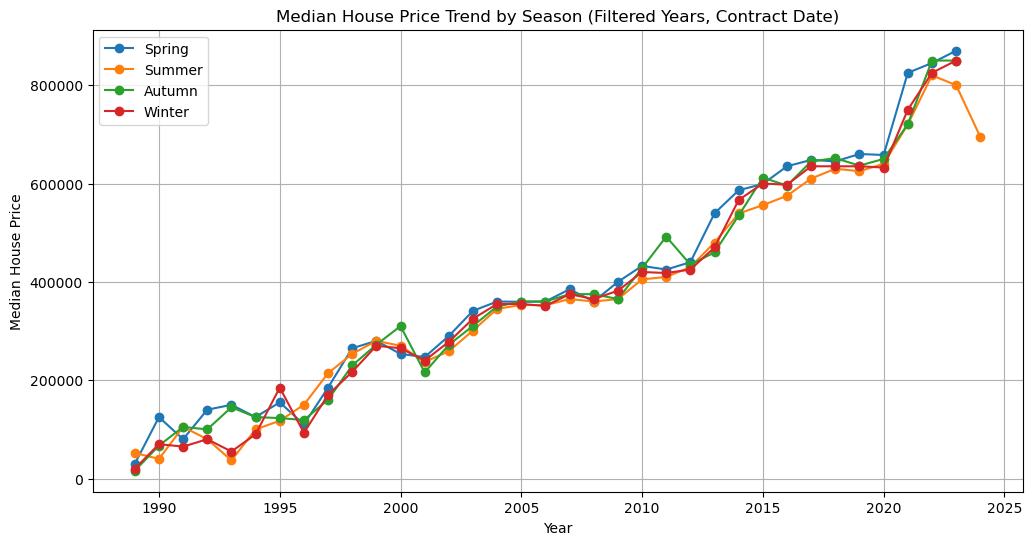

In [15]:
from pyspark.sql.functions import col, month, year, when, expr
import matplotlib.pyplot as plt

# Compute IQR bounds using a temporary year column
year_bounds = (
    property_price_df
    .withColumn("year", year(col("iso_contract_date")))
    .agg(
        expr("percentile_approx(year, 0.25)").alias("q1"),
        expr("percentile_approx(year, 0.75)").alias("q3")
    )
    .collect()[0]
)
q1, q3 = year_bounds.q1, year_bounds.q3
iqr = q3 - q1
lower_bound, upper_bound = int(q1 - 1.5*iqr), 2025

# Filter property_price_df to year bounds
property_price_df = property_price_df.filter(
    (year(col("iso_contract_date")) >= lower_bound) &
    (year(col("iso_contract_date")) <= upper_bound)
)

# Create the seasons-enriched version (adds year/month only here)
property_price_df_seasons = (
    property_price_df
    .withColumn("year", year(col("iso_contract_date")))
    .withColumn("month", month(col("iso_contract_date")))
    .withColumn(
        "season",
        when(col("month").isin(9, 10, 11), "Spring")
        .when(col("month").isin(12, 1, 2), "Summer")
        .when(col("month").isin(3, 4, 5), "Autumn")
        .when(col("month").isin(6, 7, 8), "Winter")
    )
)

# Median purchase_price per year + season
seasonal_median = (
    property_price_df_seasons
    .groupBy("year", "season")
    .agg(expr("percentile_approx(purchase_price, 0.5)").alias("median_price"))
    .orderBy("year", "season")
)

# Collect to pandas for plotting
seasonal_pdf = seasonal_median.toPandas()

plt.figure(figsize=(12,6))

for season in ["Spring", "Summer", "Autumn", "Winter"]:
    subset = seasonal_pdf[seasonal_pdf["season"] == season]
    plt.plot(subset["year"], subset["median_price"], marker="o", label=season)

plt.xlabel("Year")
plt.ylabel("Median House Price")
plt.title("Median House Price Trend by Season (Filtered Years, Contract Date)")
plt.legend()
plt.grid(True)
plt.show()



2.2.5 (Open Question) Explore the dataset freely and plot one diagram of your choice. Which columns (at least 2) are highly correlated to the sales price? Discuss the steps of your exploration and the results. (No word limit, please keep concise.) 

=== Numeric coefficients ===
        feature      coef
0   year_scaled  0.429839
1  log_area_sqm -0.138299

=== Purpose coefficients ===
                            feature      coef
9        purpose:Farm + Vacant Land -0.597411
2               purpose:Vacant Land -0.698434
6                      purpose:Farm -0.755949
8   purpose:Residence + Vacant Land -0.863692
5                purpose:Industrial -0.897766
4                purpose:Commercial -1.160271
3                    purpose:Others -1.494303
7    purpose:Residence + Commercial -2.130852
10  purpose:Industrial + Commercial -2.774417

=== Model Evaluation on Test Set ===
R²   : 0.2821
RMSE : 0.6949


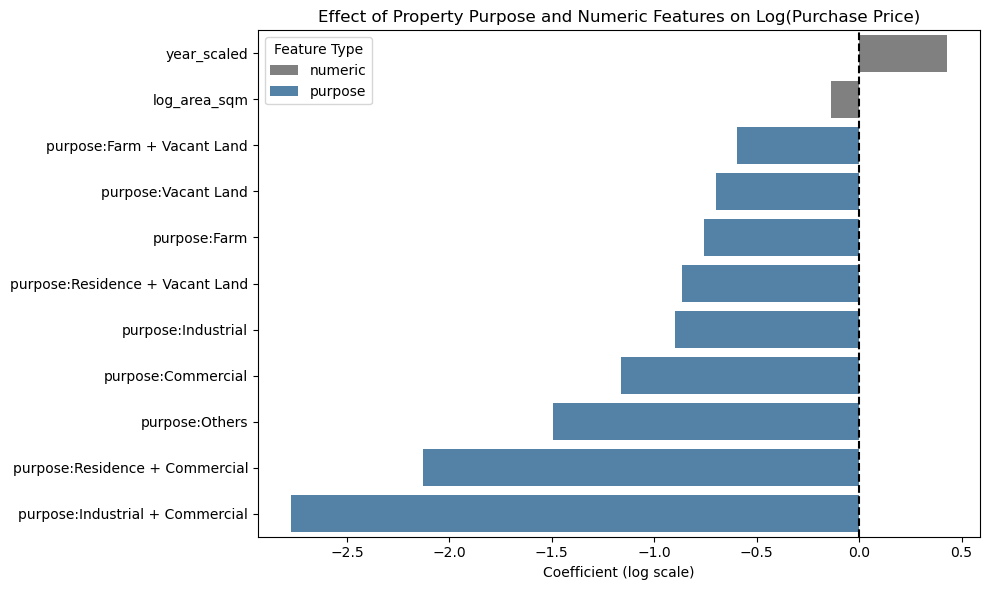

In [16]:
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# ------------------------------------------------------------
# 1) Prepare dataframe: filter + simplify
# ------------------------------------------------------------
df = (
    property_price_df
    .withColumn("year", F.year("iso_contract_date"))
    .withColumn("purchase_price", F.col("purchase_price").cast("double"))
    .withColumn("area_sqm", F.col("area_sqm").cast("double"))
    .withColumn("purpose_id", F.col("purpose_id").cast("string"))
    .select("purchase_price", "year", "area_sqm", "purpose_id")
    .dropna()
)

# IQR filtering
def iqr_filter(df, colname):
    q1, q3 = df.approxQuantile(colname, [0.25, 0.75], 0.05)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return df.filter((F.col(colname) >= lower) & (F.col(colname) <= upper))

for c in ["purchase_price", "year", "area_sqm"]:
    df = iqr_filter(df, c)

# Remove rows with 0 or negative purchase_price or area_sqm
df = df.filter(
    (F.col("purchase_price") > 0) &
    (F.col("area_sqm") > 0) &
    (F.col("year") > 0)
)
    
# Rescale year to decades since first year
min_year = df.agg(F.min("year")).collect()[0][0]
df = df.withColumn("year_scaled", (F.col("year") - F.lit(min_year)) / 10.0)

# Log-transform purchase_price and area_sqm
df = df.withColumn("log_purchase_price", F.log(F.col("purchase_price")))
df = df.withColumn("log_area_sqm", F.log(F.col("area_sqm")))

# ------------------------------------------------------------
# 2) ML pipeline: purpose_id as categorical
# ------------------------------------------------------------
purpose_indexer = StringIndexer(
    inputCol="purpose_id",
    outputCol="purpose_index",
    handleInvalid="skip"
)
purpose_encoder = OneHotEncoder(
    inputCols=["purpose_index"],
    outputCols=["purpose_ohe"]
)

assembler = VectorAssembler(
    inputCols=["year_scaled", "log_area_sqm", "purpose_ohe"],
    outputCol="features",
    handleInvalid="skip"
)

lr = LinearRegression(featuresCol="features", labelCol="log_purchase_price")

pipeline = Pipeline(stages=[purpose_indexer, purpose_encoder, assembler, lr])

# ------------------------------------------------------------
# 3) Fit model
# ------------------------------------------------------------
train, test = df.randomSplit([0.7, 0.3], seed=42)
pipeline_model = pipeline.fit(train)

lr_model = pipeline_model.stages[-1]

# ------------------------------------------------------------
# 4) Extract coefficients with labels
# ------------------------------------------------------------
purpose_indexer_model = pipeline_model.stages[0]
purpose_labels = purpose_indexer_model.labels
purpose_attrs = [f"purpose:{lbl}" for lbl in purpose_labels[1:]]  # OHE drops first category
feature_names = ["year_scaled", "log_area_sqm"] + purpose_attrs

coefs = lr_model.coefficients.toArray()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})

def lookup_label(purpose_id_str):
    try:
        # LABELS defined earlier in Q2.2.2
        return LABELS.get(int(purpose_id_str), purpose_id_str)
    except:
        return purpose_id_str

coef_df["feature"] = coef_df["feature"].apply(
    lambda x: f"purpose:{lookup_label(x.split(':')[1])}" if x.startswith("purpose:") else x
)

# ------------------------------------------------------------
# 5) Show results
# ------------------------------------------------------------
print("=== Numeric coefficients ===")
print(coef_df[coef_df["feature"].isin(["year_scaled", "log_area_sqm"])])

print("\n=== Purpose coefficients ===")
print(coef_df[coef_df["feature"].str.startswith("purpose:")].sort_values("coef", ascending=False))

# ------------------------------------------------------------
# 6) Evaluate on test set
# ------------------------------------------------------------
from pyspark.ml.evaluation import RegressionEvaluator

preds = pipeline_model.transform(test)

evaluator_r2 = RegressionEvaluator(
    labelCol="log_purchase_price", predictionCol="prediction", metricName="r2"
)
evaluator_rmse = RegressionEvaluator(
    labelCol="log_purchase_price", predictionCol="prediction", metricName="rmse"
)

r2 = evaluator_r2.evaluate(preds)
rmse = evaluator_rmse.evaluate(preds)

print("\n=== Model Evaluation on Test Set ===")
print(f"R²   : {r2:.4f}")
print(f"RMSE : {rmse:,.4f}")  # in log-space

# Combine all coefficients
coef_plot_df = coef_df.copy()
coef_plot_df["type"] = coef_plot_df["feature"].apply(
    lambda x: "numeric" if x in ["year_scaled", "log_area_sqm"] else "purpose"
)
coef_plot_df["label"] = coef_plot_df["feature"].apply(
    lambda x: x if x not in ["year_scaled", "log_area_sqm"] else x
)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=coef_plot_df.sort_values("coef", ascending=False),
    x="coef",
    y="label",
    hue="type",
    dodge=False,
    palette={"numeric":"gray", "purpose":"steelblue"}
)
plt.axvline(0, color="black", linestyle="--")
plt.title("Effect of Property Purpose and Numeric Features on Log(Purchase Price)")
plt.xlabel("Coefficient (log scale)")
plt.ylabel("")
plt.legend(title="Feature Type")
plt.tight_layout()
plt.show()


Discussion:  
Intuitively, the variables we expect to affect property price are the year, the size of the property, the location 
of the property, and the type of property it is. However, measuring the effects of location on the property proved 
to be difficult for a number of reasons:
    1. zone_id, council_id have many items in them with no clear description on what they are, 
    yet they contain many items in the dataset.
    2. post_code has too many variables in it, making it difficult to analyze the entire dataset by postcode due 
    to processing power limitations.
    3. many erroneous outliers exist in the dataset, which skews the trends towards "which areas had erroneous entries" 
    rather than actual meaningful data.
To avoid this, we only analyze numeric variables and categorical variables with larger buckets to act as a noise 
averaging filter, which leads to measuring year, area_sqm and the updated primary_purpose from Q2.2.2.

Even after that, with area_sqm showing a negative correlation, it shows that other conflating factors like location,
type of property or simply the trend of inflation over the years is dominating the price analysis.


### Part 3 RDDs vs DataFrame vs Spark SQL (25%) <a class="anchor" name="part-3"></a>
Implement the following complex queries using RDD, DataFrame in SparkSQL separately(choose two). Log the time taken for each query in each approach using the “%%time” built-in magic command in Jupyter Notebook and discuss the performance difference between these 2 approaches of your choice.
(notes: You can write a multi-step query or a single complex query, the choice is yours. You can reuse the data frame in Part 2.)

#### Complex Query:
<pre>
A property investor wants to understand whether the property price and the settlement date are correlated. Here is the conditions:
1)	The investor is only interested in the last 2 years of the dataset.
2)	The investor is looking at houses under $2 million.
3)	Perform a bucketing of the settlement date (settlement – contract date
range (15, 30, 45, 60, 90 days).
4)	Perform a bucketing of property prices in $500K(e.g. 0-$500K, $500K-$1M, $1M-$1.5M, $1.5-$2M)
5)	Count the number of transactions in each combination and print the result in the following format
(Note: It’s fine to count the same property multiple times in this task, it’s based on sales transactions).
(Note: You shall show the full table with 40 rows, 2 years *4 price bucket * 5 settlement bucket; 0 count should be displayed as 0, not omitted.)
</pre>

### a)	Implement the above query using two approaches of your choice separately and print the results. (Note: Outputs from both approaches of your choice are required, and the results should be the same.). 

#### 3.1. Implementation 1

In [17]:
%%time
from pyspark.sql import functions as F

# === Parse contract & settlement dates ===
df_dates = (
    property_price_df
    .withColumn("settlement_date", F.col("iso_settlement_date").cast("date"))
    .withColumn("contract_date", F.col("iso_contract_date").cast("date"))
    .withColumn("purchase_price", F.col("purchase_price").cast("double"))
    .withColumn("settlement_days", F.datediff("settlement_date", "contract_date"))
)

# === Restrict to houses ≤ 2025 ===
df_dates = df_dates.filter(
    (F.year("settlement_date") <= 2025) & 
    (F.col("property_type") == "house")
)

# === Find latest settlement_date and define cutoff (last 2 years) ===
latest_date = df_dates.agg(F.max("settlement_date")).collect()[0][0]

if latest_date is None:
    print("No valid settlement_date values found after filtering (<=2025).")
else:
    cutoff_date = F.add_months(F.lit(latest_date), -24)
    df_last2y = df_dates.filter(F.col("settlement_date") >= cutoff_date)

    # === Restrict to properties under $2M ===
    df_under2m = df_last2y.filter(F.col("purchase_price") < 2000000)

    # === Settlement gap in days ===
    df_gap = df_under2m.withColumn(
        "settlement_days",
        F.datediff(F.col("settlement_date"), F.col("contract_date"))
    )

    # === Settlement buckets ===
    df_buckets = df_gap.withColumn(
        "settlement_bucket",
        F.when(F.col("settlement_days") <= 15, "≤15d")
         .when(F.col("settlement_days") <= 30, "16–30d")
         .when(F.col("settlement_days") <= 45, "31–45d")
         .when(F.col("settlement_days") <= 60, "46–60d")
         .when(F.col("settlement_days") <= 90, "61–90d")
    ).filter(F.col("settlement_bucket").isNotNull())

    # === Price buckets in 500K steps ===
    df_buckets = df_buckets.withColumn(
        "price_bucket",
        F.when(F.col("purchase_price") < 500000, "0–500K")
         .when(F.col("purchase_price") < 1000000, "500K–1M")
         .when(F.col("purchase_price") < 1500000, "1M–1.5M")
         .when(F.col("purchase_price") < 2000000, "1.5M–2M")
    )

    # === Year of sale from contract_date ===
    df_buckets = df_buckets.withColumn("year", F.year("contract_date"))

    # === Count transactions ===
    df_counts = (
        df_buckets
        .groupBy("year", "price_bucket", "settlement_bucket")
        .agg(F.count("*").alias("transaction_count"))
    )

    # === Build full 40-row grid ===
    years = [latest_date.year, latest_date.year - 1]
    price_buckets = ["0–500K", "500K–1M", "1M–1.5M", "1.5M–2M"]
    settlement_buckets = ["≤15d", "16–30d", "31–45d", "46–60d", "61–90d"]

    years_df = spark.createDataFrame([(y,) for y in years], ["year"])
    prices_df = spark.createDataFrame([(p,) for p in price_buckets], ["price_bucket"])
    settles_df = spark.createDataFrame([(s,) for s in settlement_buckets], ["settlement_bucket"])

    grid_df = years_df.crossJoin(prices_df).crossJoin(settles_df)

    # === Join with counts, fill 0s ===
    final_df = (
        grid_df
        .join(df_counts, ["year","price_bucket","settlement_bucket"], "left")
        .fillna(0, subset=["transaction_count"])
        .orderBy("year", "price_bucket", "settlement_bucket")
    )

    final_df.show(40, truncate=False)


+----+------------+-----------------+-----------------+
|year|price_bucket|settlement_bucket|transaction_count|
+----+------------+-----------------+-----------------+
|2023|0–500K      |16–30d           |5633             |
|2023|0–500K      |31–45d           |6375             |
|2023|0–500K      |46–60d           |1392             |
|2023|0–500K      |61–90d           |1107             |
|2023|0–500K      |≤15d             |3123             |
|2023|1.5M–2M     |16–30d           |923              |
|2023|1.5M–2M     |31–45d           |3889             |
|2023|1.5M–2M     |46–60d           |1952             |
|2023|1.5M–2M     |61–90d           |2149             |
|2023|1.5M–2M     |≤15d             |316              |
|2023|1M–1.5M     |16–30d           |2522             |
|2023|1M–1.5M     |31–45d           |8417             |
|2023|1M–1.5M     |46–60d           |3499             |
|2023|1M–1.5M     |61–90d           |3310             |
|2023|1M–1.5M     |≤15d             |699        

#### 3.2. Implementation 2

In [18]:
%%time
# Register the DataFrame as a SQL temp view
property_price_df.createOrReplaceTempView("property_price")

# === Parse dates and restrict to houses ≤ 2025 ===
spark.sql("""
    CREATE OR REPLACE TEMP VIEW parsed AS
    SELECT
        CAST(iso_settlement_date AS DATE) AS settlement_date,
        CAST(iso_contract_date AS DATE) AS contract_date,
        CAST(purchase_price AS DOUBLE) AS purchase_price,
        property_type
    FROM property_price
    WHERE year(CAST(iso_settlement_date AS DATE)) <= 2025
      AND property_type = 'house'
""")

# === Latest settlement date ===
latest_date = spark.sql("SELECT max(settlement_date) as max_date FROM parsed").collect()[0][0]

if latest_date is not None:
    cutoff_date = latest_date.replace(year=latest_date.year - 2)

    # === Filter last 2 years, < $2M ===
    spark.sql(f"""
        CREATE OR REPLACE TEMP VIEW filtered AS
        SELECT *,
               datediff(settlement_date, contract_date) as settlement_days
        FROM parsed
        WHERE settlement_date >= DATE('{cutoff_date}')
          AND purchase_price < 2000000
    """)
    # === Settlement bucketing ===
    spark.sql("""
        CREATE OR REPLACE TEMP VIEW settlement_bucketed AS
        SELECT *,
            CASE
                WHEN settlement_days <= 15 THEN '≤15d'
                WHEN settlement_days <= 30 THEN '16–30d'
                WHEN settlement_days <= 45 THEN '31–45d'
                WHEN settlement_days <= 60 THEN '46–60d'
                WHEN settlement_days <= 90 THEN '61–90d'
            END AS settlement_bucket
        FROM filtered
        WHERE settlement_days IS NOT NULL
          AND settlement_days <= 90
    """)

    # === Price bucketing ===
    spark.sql("""
        CREATE OR REPLACE TEMP VIEW bucketed AS
        SELECT *,
            CASE
                WHEN purchase_price <  500000 THEN '0–500K'
                WHEN purchase_price < 1000000 THEN '500K–1M'
                WHEN purchase_price < 1500000 THEN '1M–1.5M'
                WHEN purchase_price < 2000000 THEN '1.5M–2M'
            END AS price_bucket,
            year(contract_date) as year
        FROM settlement_bucketed
    """)

    # === Group counts ===
    spark.sql("""
        CREATE OR REPLACE TEMP VIEW counts AS
        SELECT
            year,
            price_bucket,
            settlement_bucket,
            COUNT(*) AS transaction_count
        FROM bucketed
        GROUP BY year, price_bucket, settlement_bucket
    """)

    # === Build 40-row grid ===
    years = [latest_date.year, latest_date.year - 1]
    price_buckets = ["0–500K", "500K–1M", "1M–1.5M", "1.5M–2M"]
    settlement_buckets = ["≤15d", "16–30d", "31–45d", "46–60d", "61–90d"]

    years_df = spark.createDataFrame([(y,) for y in years], ["year"])
    prices_df = spark.createDataFrame([(p,) for p in price_buckets], ["price_bucket"])
    settles_df = spark.createDataFrame([(s,) for s in settlement_buckets], ["settlement_bucket"])

    grid_df = years_df.crossJoin(prices_df).crossJoin(settles_df)
    grid_df.createOrReplaceTempView("grid")

    # === Left join with counts ===
    final_df = spark.sql("""
        SELECT
            g.year,
            g.price_bucket,
            g.settlement_bucket,
            COALESCE(c.transaction_count, 0) as transaction_count
        FROM grid g
        LEFT JOIN counts c
          ON g.year = c.year
         AND g.price_bucket = c.price_bucket
         AND g.settlement_bucket = c.settlement_bucket
        ORDER BY g.year, g.price_bucket, g.settlement_bucket
    """)

    final_df.show(40, truncate=False)


+----+------------+-----------------+-----------------+
|year|price_bucket|settlement_bucket|transaction_count|
+----+------------+-----------------+-----------------+
|2023|0–500K      |16–30d           |5633             |
|2023|0–500K      |31–45d           |6375             |
|2023|0–500K      |46–60d           |1392             |
|2023|0–500K      |61–90d           |1107             |
|2023|0–500K      |≤15d             |3123             |
|2023|1.5M–2M     |16–30d           |923              |
|2023|1.5M–2M     |31–45d           |3889             |
|2023|1.5M–2M     |46–60d           |1952             |
|2023|1.5M–2M     |61–90d           |2149             |
|2023|1.5M–2M     |≤15d             |316              |
|2023|1M–1.5M     |16–30d           |2522             |
|2023|1M–1.5M     |31–45d           |8417             |
|2023|1M–1.5M     |46–60d           |3499             |
|2023|1M–1.5M     |61–90d           |3310             |
|2023|1M–1.5M     |≤15d             |699        

### b)	Which one is easier to implement, in your opinion? Log the time taken for each query, and observe the query execution time, among DataFrame and SparkSQL, which is faster and why? Please include proper references. (Maximum 500 words.) 

DataFrames and SparkSQL are quite similar in operations, and while I think SparkSQL has a more intuitive syntax usage, I am more used to DataFrames as they are more similar to the typical Python programming I am experienced in. Moreover, it's easier for me to debug errors in DataFrames, as they aren't wrapped in wrappers and I can access variables to check more directly.

The query execution time is similar, as they have the same execution engine (Spark SQL and DataFrames - SpArk 4.0.1 Documentation, n.d.), so any difference in query speeds are just differences in how the logical plan was expressed. 

Spark SQL and DataFrames - SpArk 4.0.1 Documentation. (n.d.). https://spark.apache.org/docs/latest/sql-programming-guide.html

### Some ideas on the comparison

Armbrust, M., Huai, Y., Liang, C., Xin, R., & Zaharia, M. (2015). Deep Dive into Spark SQL’s Catalyst Optimizer. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html

Damji, J. (2016). A Tale of Three Apache Spark APIs: RDDs, DataFrames, and Datasets. Retrieved September 28, 2017, from https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html

Data Flair (2017a). Apache Spark RDD vs DataFrame vs DataSet. Retrieved September 28, 2017, from http://data-flair.training/blogs/apache-spark-rdd-vs-dataframe-vs-dataset

Prakash, C. (2016). Apache Spark: RDD vs Dataframe vs Dataset. Retrieved September 28, 2017, from http://why-not-learn-something.blogspot.com.au/2016/07/apache-spark-rdd-vs-dataframe-vs-dataset.html

Xin, R., & Rosen, J. (2015). Project Tungsten: Bringing Apache Spark Closer to Bare Metal. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/28/project-tungsten-bringing-spark-closer-to-bare-metal.html

AI Declaration:  
I used ChatGPT to stitch my messy code blocks together to form neatly organized code, and to find cleaner ways of doing the same thing.